<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Récupération-des-données" data-toc-modified-id="1.-Récupération-des-données-1">1. Récupération des données</a></span></li><li><span><a href="#2.-Evaluation-du-nombre-de-clusters" data-toc-modified-id="2.-Evaluation-du-nombre-de-clusters-2">2. Evaluation du nombre de clusters</a></span></li><li><span><a href="#3.-Comparaison-des-modèles-de-clustering" data-toc-modified-id="3.-Comparaison-des-modèles-de-clustering-3">3. Comparaison des modèles de clustering</a></span><ul class="toc-item"><li><span><a href="#3.1.-Clustering-hiérarchique" data-toc-modified-id="3.1.-Clustering-hiérarchique-3.1">3.1. Clustering hiérarchique</a></span></li><li><span><a href="#3.2.-k-means" data-toc-modified-id="3.2.-k-means-3.2">3.2. k-means</a></span></li><li><span><a href="#3.3.-DBSCAN" data-toc-modified-id="3.3.-DBSCAN-3.3">3.3. DBSCAN</a></span></li><li><span><a href="#3.4.-Choix-du-meilleur-modèle" data-toc-modified-id="3.4.-Choix-du-meilleur-modèle-3.4">3.4. Choix du meilleur modèle</a></span></li></ul></li><li><span><a href="#4.-Caractérisation-des-clusters" data-toc-modified-id="4.-Caractérisation-des-clusters-4">4. Caractérisation des clusters</a></span><ul class="toc-item"><li><span><a href="#4.1.-Stabilité-à-l'initialisation" data-toc-modified-id="4.1.-Stabilité-à-l'initialisation-4.1">4.1. Stabilité à l'initialisation</a></span></li><li><span><a href="#4.2.-Silhouette-plot" data-toc-modified-id="4.2.-Silhouette-plot-4.2">4.2. Silhouette plot</a></span></li><li><span><a href="#4.3.-Description-des-clusters" data-toc-modified-id="4.3.-Description-des-clusters-4.3">4.3. Description des clusters</a></span></li></ul></li></ul></div>

# Segmentez des clients d'un site e-commerce - Essais

In [1]:
import os

import matplotlib as mlp
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import cluster, metrics

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 1. Récupération des données

In [2]:
path = "./data/cleaned/"
filename = "final_data.csv"

In [3]:
# create dataframe
data = pd.read_csv(path + filename)
data.head()

,last_order,mean_delivery_time,mean_price,mean_review_score,total_price,total_orders,delivered_ratio,recency
0,2018-05-10 11:11:18,2.001604,4.874434,5.0,4.874434,1,1.0,4.762174
1,2018-05-07 18:25:44,1.382288,2.990720,4.0,2.990720,1,1.0,4.779123
2,2017-03-10 21:05:03,3.285852,4.248495,3.0,4.248495,1,1.0,6.295266
3,2017-10-12 20:49:17,3.045640,3.295466,4.0,3.295466,1,1.0,5.786897
4,2017-11-14 20:06:52,2.648048,5.198497,5.0,5.198497,1,1.0,5.680173


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94914 entries, 0 to 94913
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_order          94914 non-null  object 
 1   mean_delivery_time  94914 non-null  float64
 2   mean_price          94914 non-null  float64
 3   mean_review_score   94914 non-null  float64
 4   total_price         94914 non-null  float64
 5   total_orders        94914 non-null  int64  
 6   delivered_ratio     94914 non-null  float64
 7   recency             94914 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 5.8+ MB


Vérifions les dates maxi et mini de notre jeu de données.

In [5]:
data['last_order'].agg(['min', 'max'])

min    2016-09-15 12:16:38
max    2018-09-03 17:40:06
Name: last_order, dtype: object

On a un intervalle de 2 ans entre la première et la dernière date. Mais comme on l'a vu dans l'analyse exploratoire au niveau du chiffre d'affaire, il y a un creux dans les dates entre octobre 2016 et janvier 2017. Pour ne pas perdre de données, je vais prendre comme date de départ le 01/02/2017. Je crée un jeu sur les 8 premiers mois. 

Comme on l'a vu aussi dans l'analyse, l'évolution du nombre de clients dans le temps est constante. Ces 8 premiers mois prendront en compte l'arrivée de nouveaux clients. Même chose pour le nombre de commandes.

In [6]:
start_date = '2017-02-01 00:00:00'
end_date = '2017-09-30 23:59:59'

mask = (data['last_order'] >= start_date) & (data['last_order'] <= end_date)
select_data = data.loc[mask]

Je supprime la date last_order.

In [7]:
X = select_data.drop(['last_order'], axis=1)

Je standardise les données.

In [8]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

## 2. Evaluation du nombre de clusters

L'évaluation du nombre de clusters est réalisée par PCA.

In [9]:
# instanciate ACP
pca = PCA(svd_solver='full').fit(X_scaled)

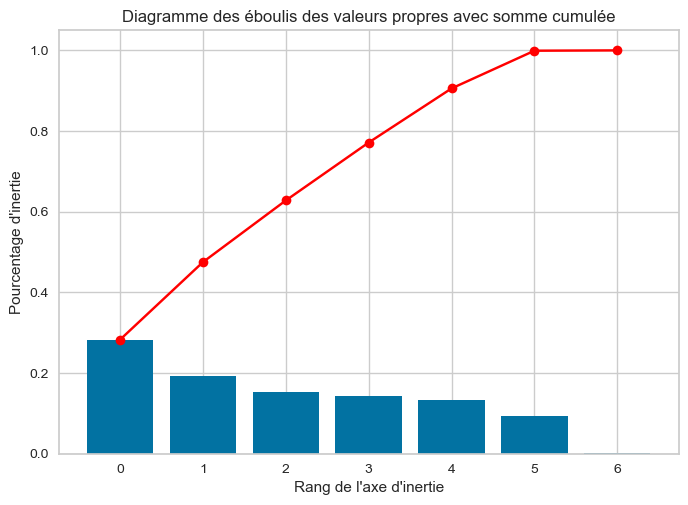

In [10]:
# explained variance
explained_variance = pca.explained_variance_ratio_

# scree plot
plt.figure()
plt.bar(np.arange(len(explained_variance)), explained_variance)
plt.plot(np.arange(len(explained_variance)),
         explained_variance.cumsum(), c="red", marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Diagramme des éboulis des valeurs propres avec somme cumulée")
plt.show()

On couvre 100% de l'inertie totale avec 5 clusters. Vérifions cette valeur avec les modèles.

## 3. Comparaison des modèles de clustering

### 3.1. Clustering hiérarchique

Score de silhouette : 0.5873247030477742
Index de Davies-Bouldin : 0.6631501896292655


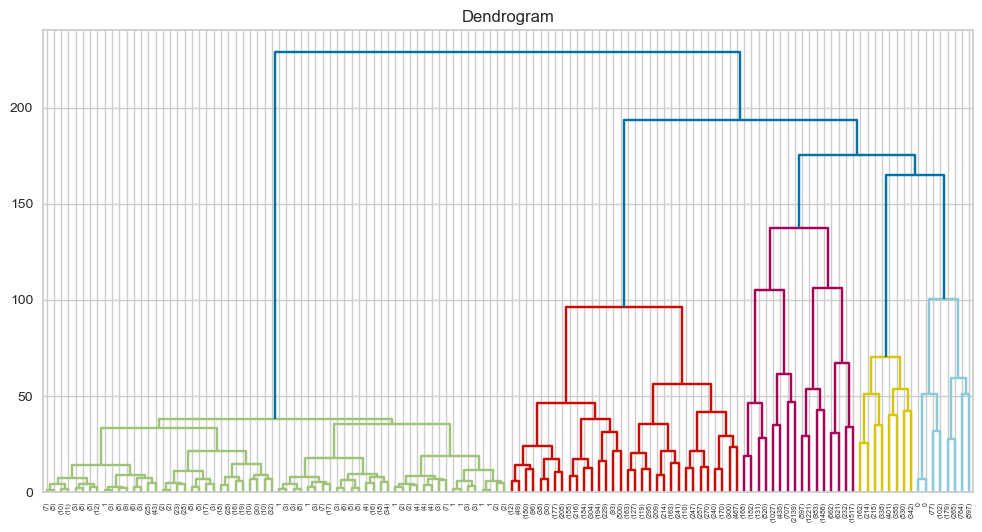

In [11]:
# instanciate AgglomerativeClustering
agg_clustering = cluster.AgglomerativeClustering()
# fit scaled datas
agg_clustering.fit(X_scaled)
# get labels
labels = agg_clustering.labels_
# calculate silhouette score
silh_score = metrics.silhouette_score(X_scaled, labels)
print("Score de silhouette : {}".format(silh_score))
# calculate davies-bouldin index
dabo_index = metrics.davies_bouldin_score(X_scaled, labels)
print("Index de Davies-Bouldin : {}".format(dabo_index))

# perform clustering and uses the Ward variance minimization algorithm
linkage_matrix = linkage(X_scaled, method='ward')

# create dendogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation="top",
           labels=labels, truncate_mode="level", p=6)
plt.title('Dendrogram')
plt.show()

### 3.2. k-means

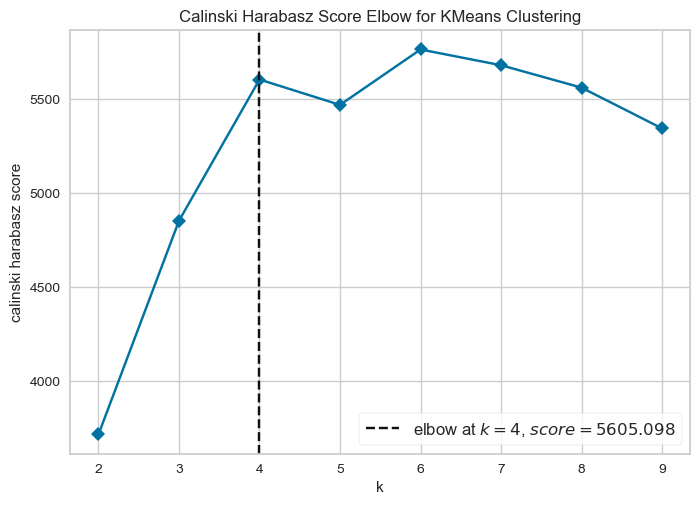

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [12]:
# instanciate KMeans
model = cluster.KMeans(random_state=42, n_init=1)

"""
Create elbow visualizer 
calinski_harabasz: computes the ratio of dispersion between and within clusters
"""
visualizer = KElbowVisualizer(model, k=(
    2, 10), metric='calinski_harabasz', timings=False, locate_elbow=True)

# fit the data to the visualizer
visualizer.fit(X_scaled)
visualizer.show()

Cette méthode nous donne 4 clusters.

Jouons sur les hyperparamètres pour obtenir les meilleurs métriques et déterminer le numbre de clusters.

In [13]:
k_silhouettes = []
k_indexes = []
k_wss = []
for j in range(3, 10):
    # instanciate KMeans with 3 to 10 clusters
    kmeans = cluster.KMeans(n_clusters=j, n_init=1, random_state=42)
    # fit datas
    kmeans.fit(X_scaled)
    # calculate silhouette score
    k_silh = metrics.silhouette_score(X_scaled, kmeans.labels_)
    k_silhouettes.append(k_silh)
    # calcultate davies-bouldin index
    k_index = metrics.davies_bouldin_score(X_scaled, kmeans.labels_)
    k_indexes.append(k_index)
    # get intertia
    k_wss.append(kmeans.inertia_)
    print("Nombre de clusters : {}, avec un score de silhouette de : {}".format(j, k_silh))
    print("Nombre de clusters : {}, avec un index de Davies-Bouldin de : {}".format(j, k_index))

Nombre de clusters : 3, avec un score de silhouette de : 0.19995651716449922
Nombre de clusters : 3, avec un index de Davies-Bouldin de : 1.6528745331238135
Nombre de clusters : 4, avec un score de silhouette de : 0.22079040430249608
Nombre de clusters : 4, avec un index de Davies-Bouldin de : 1.3859963902261474
Nombre de clusters : 5, avec un score de silhouette de : 0.19299232237823402
Nombre de clusters : 5, avec un index de Davies-Bouldin de : 1.3164626570171483
Nombre de clusters : 6, avec un score de silhouette de : 0.21136819352243938
Nombre de clusters : 6, avec un index de Davies-Bouldin de : 1.222511314852704
Nombre de clusters : 7, avec un score de silhouette de : 0.20505698415796997
Nombre de clusters : 7, avec un index de Davies-Bouldin de : 1.1826659298233886
Nombre de clusters : 8, avec un score de silhouette de : 0.20588458186944594
Nombre de clusters : 8, avec un index de Davies-Bouldin de : 1.1664345752014111
Nombre de clusters : 9, avec un score de silhouette de : 0.

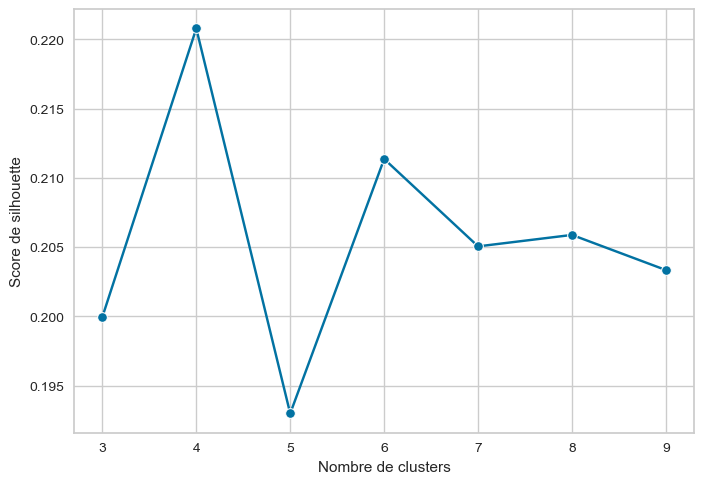

In [14]:
# plot silhouette scores
sns.lineplot(x=range(3, 10), y=k_silhouettes, marker="o", dashes=False)
plt.xticks(range(3, 10))
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.show()

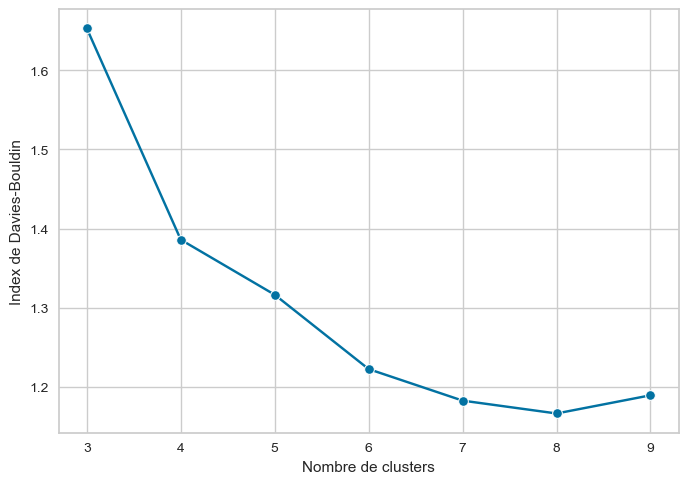

In [15]:
# plot davies-bouldin indexes
sns.lineplot(x=range(3, 10), y=k_indexes, marker="o", dashes=False)
plt.xticks(range(3, 10))
plt.xlabel("Nombre de clusters")
plt.ylabel("Index de Davies-Bouldin")
plt.show()

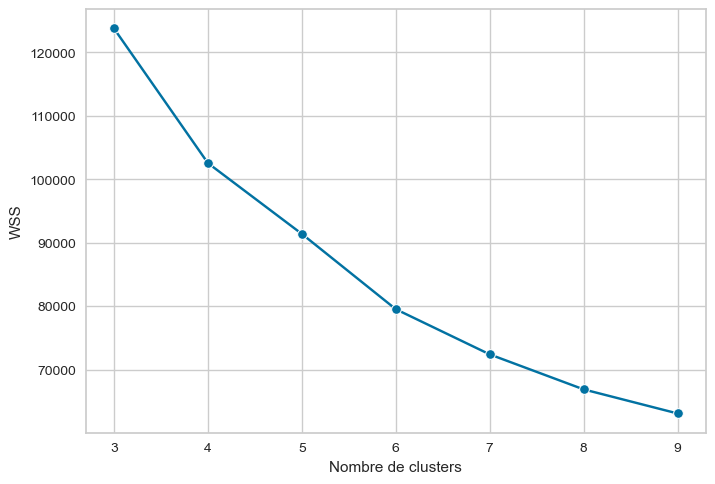

In [16]:
# plot inertia
sns.lineplot(x=range(3, 10), y=k_wss, marker="o", dashes=False)
plt.xticks(range(3, 10))
plt.xlabel("Nombre de clusters")
plt.ylabel("WSS")
plt.show()

On obtient les meilleurs scores avec 6 clusters :

- Nombre de clusters : 6, avec un score de silhouette de : 0.21136819352243938
- Nombre de clusters : 6, avec un index de Davies-Bouldin de : 1.222511314852704

Avec la méthode du coude, on est également à 6 clusters.

Evaluons la forme des clusters avec t-SNE (T-distributed Stochastic Neighbor Embedding).

In [17]:
# 2 dimensions
tsne = TSNE(n_components=2)
np_tsne = tsne.fit_transform(X_scaled)

In [18]:
# instantiate KMeans with 6 clusters
kmeans = cluster.KMeans(n_clusters=6, n_init=1, random_state=42)
kmeans.fit(X_scaled)
km_labels = kmeans.labels_

In [19]:
# create dataframe with each client (x and y coordinates) in each cluster
km_tsne = pd.DataFrame(
    {'x': np_tsne[:, 0], 'y': np_tsne[:, 1], 'labels': km_labels})

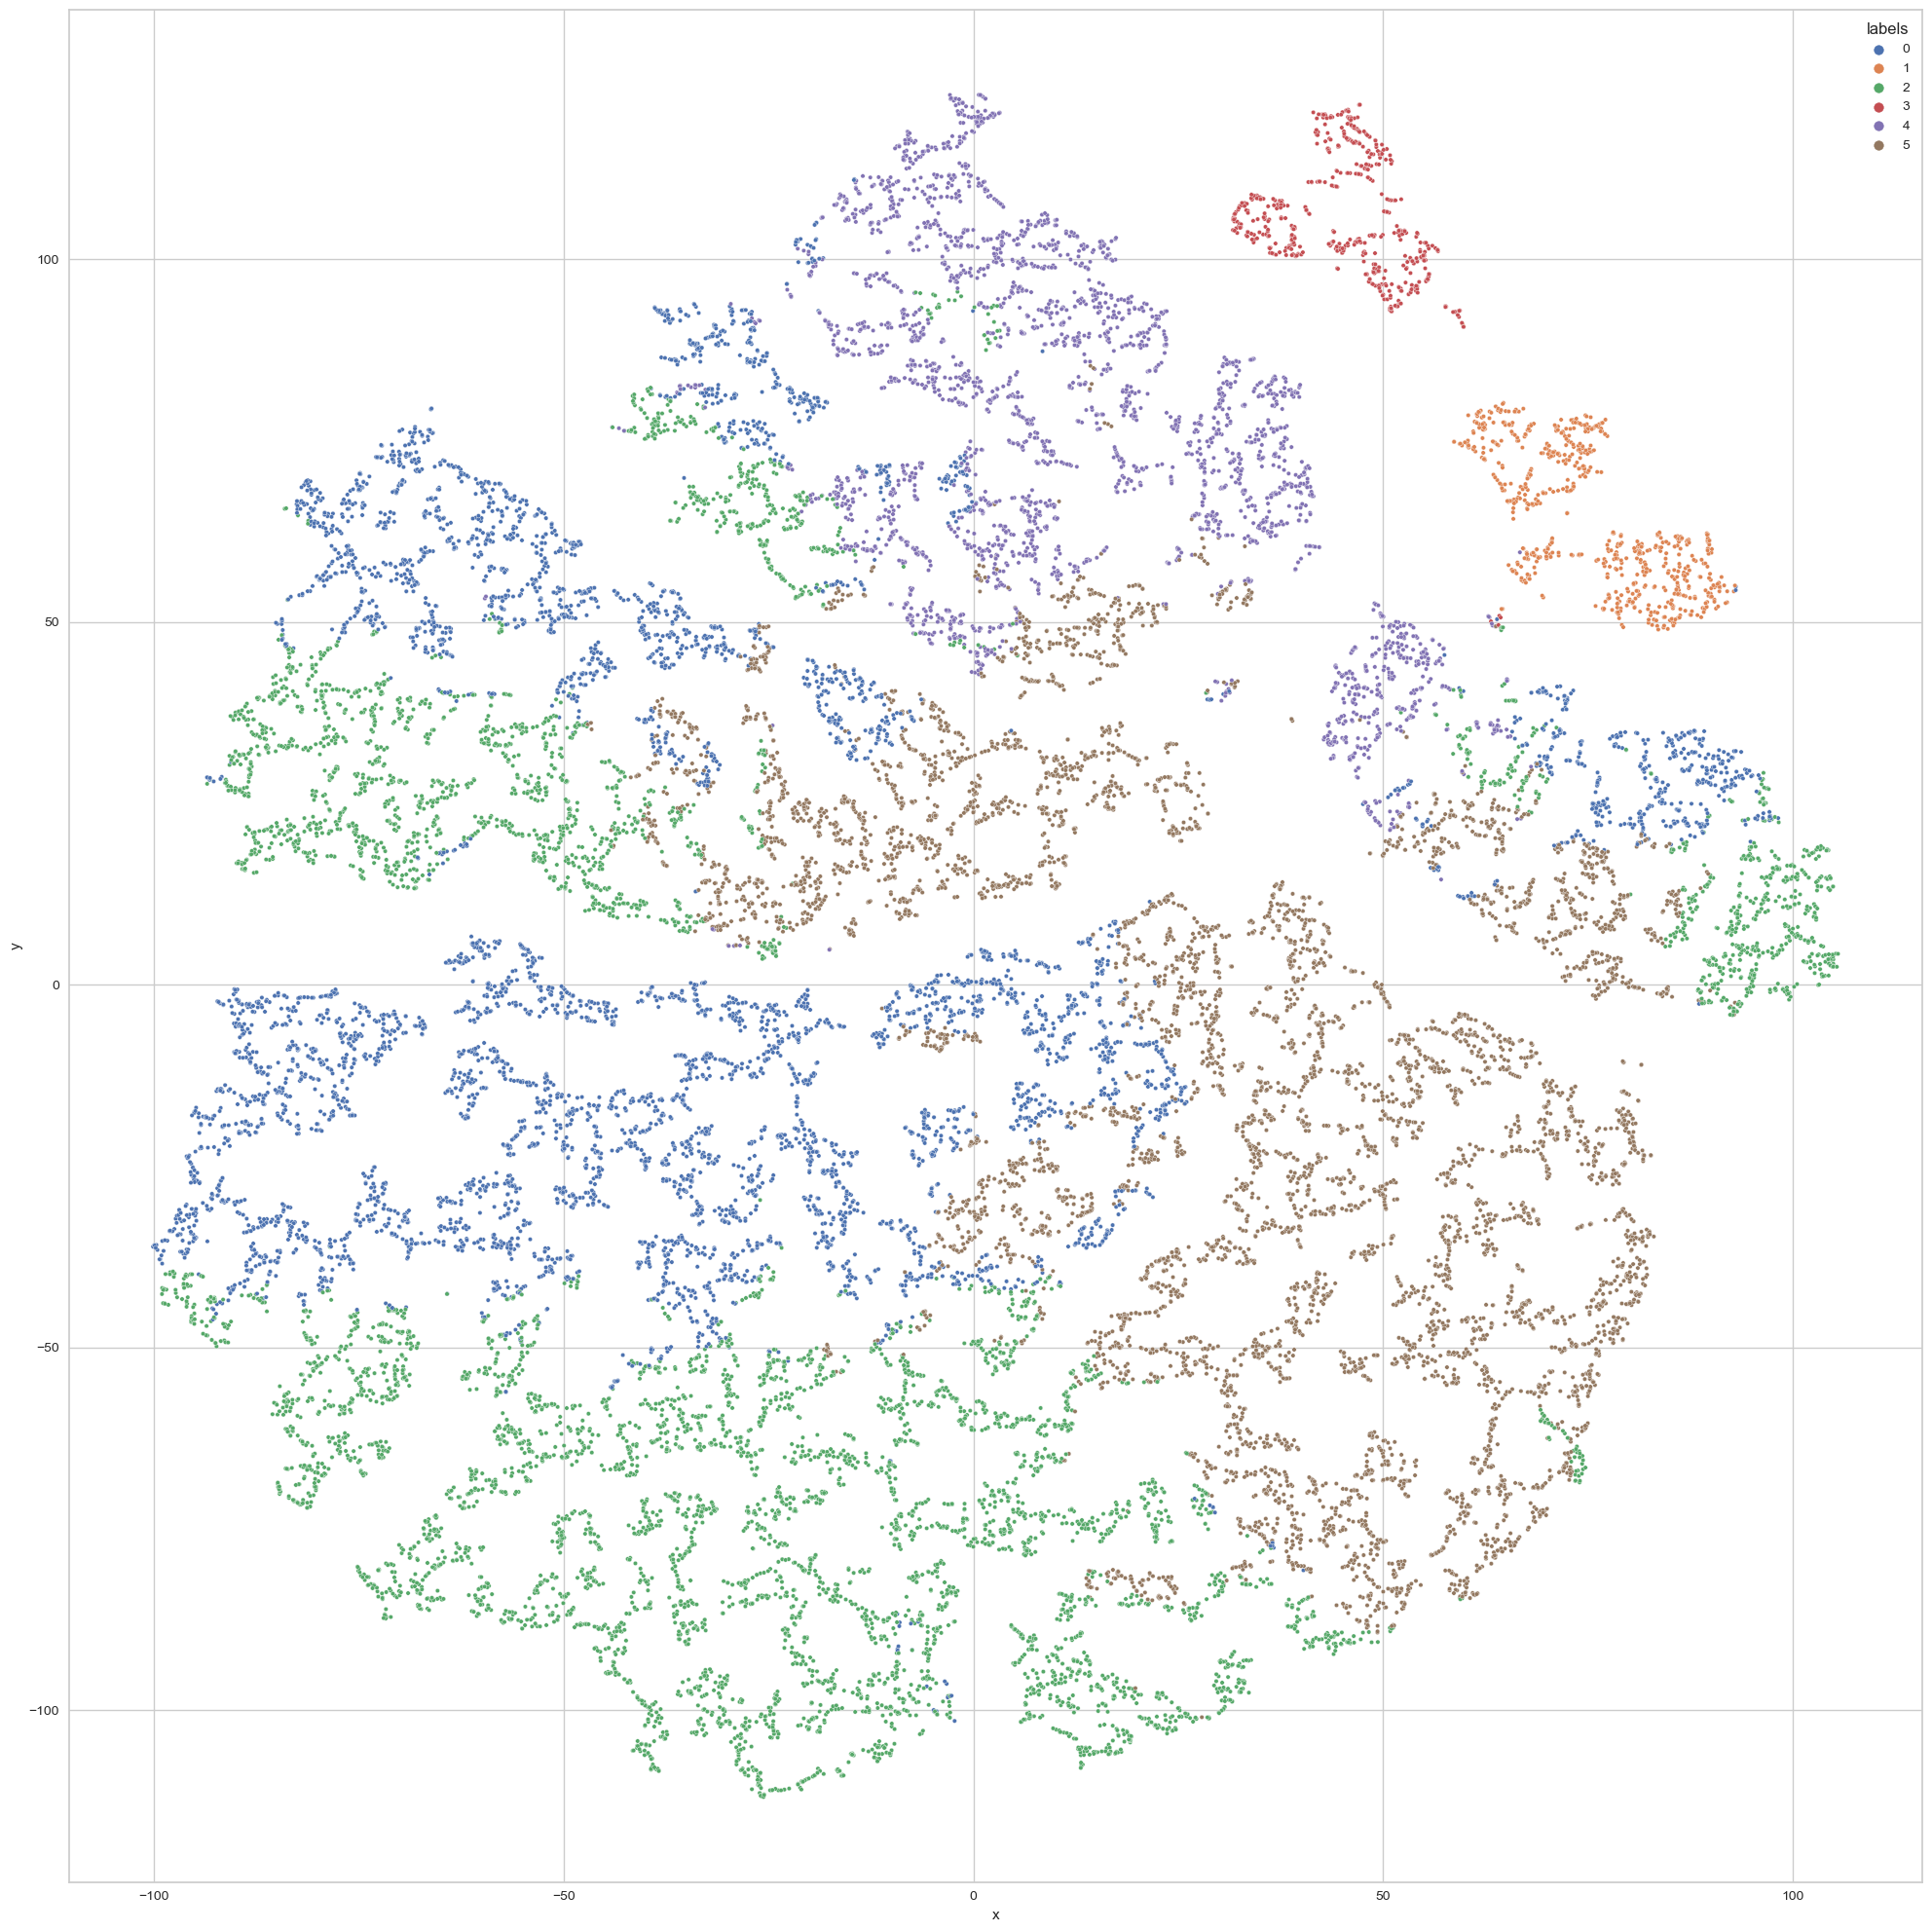

In [20]:
# plotting clusters
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
sns.scatterplot(x=km_tsne['x'], y=km_tsne['y'], s=10,
                hue=km_tsne['labels'], palette="deep")

plt.tight_layout()
plt.show()

### 3.3. DBSCAN

In [21]:
db_silhouettes = []
db_indexes = []
db_clusters = []
for i in np.arange(0.5, 3, 0.5):
    # instanciate DBSCAN with 0.5 to 3 epsilon value with a step of 0.5
    dbscan = cluster.DBSCAN(eps=i, min_samples=5)
    # get labels
    labels = dbscan.fit_predict(X_scaled)
    # get number of clusters
    nb_clusters = len(set(labels))
    db_clusters.append(nb_clusters)
    # calculate silhouette score
    db_sil = metrics.silhouette_score(X_scaled, labels)
    db_silhouettes.append(db_sil)
    # calculate davies-bouldin index
    db_index = metrics.davies_bouldin_score(X_scaled, labels)
    db_indexes.append(db_index)
    print("Epsilon : {}, avec {} clusters : {}".format(
        i, nb_clusters, set(labels)))
    print("Epsilon : {}, avec un score de silhouette de : {}".format(i, db_sil))
    print("Epsilon : {}, avec un index de Davies-Bouldin de : {}".format(i, db_index))

Epsilon : 0.5, avec 73 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, -1}
Epsilon : 0.5, avec un score de silhouette de : -0.19521323183095735
Epsilon : 0.5, avec un index de Davies-Bouldin de : 1.887195505839484
Epsilon : 1.0, avec 15 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
Epsilon : 1.0, avec un score de silhouette de : 0.12215917446537351
Epsilon : 1.0, avec un index de Davies-Bouldin de : 1.9511047913947657
Epsilon : 1.5, avec 10 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Epsilon : 1.5, avec un score de silhouette de : 0.1609199220484011
Epsilon : 1.5, avec un index de Davies-Bouldin de : 2.4395151400318804
Epsilon : 2.0, avec 4 clusters : {0, 1, 2, -1}
Epsilon : 2.0, avec un score de silhouette de : 0.3475962569390413
Ep

On va affiner les epsilons pour essayer d'obtenir de meilleurs scores

In [22]:
db_silhouettes = []
db_indexes = []
db_clusters = []
for i in np.arange(1, 2, 0.1):
    # instanciate DBSCAN with 1 to 2 epsilon value with a step of 0.1
    dbscan = cluster.DBSCAN(eps=i, min_samples=5)
    # get labels
    labels = dbscan.fit_predict(X_scaled)
    # get number of clusters
    nb_clusters = len(set(labels))
    db_clusters.append(nb_clusters)
    # calculate silhouette score
    db_sil = metrics.silhouette_score(X_scaled, labels)
    db_silhouettes.append(db_sil)
    # calculate davies-bouldin index
    db_index = metrics.davies_bouldin_score(X_scaled, labels)
    db_indexes.append(db_index)
    print("Epsilon : {}, avec {} clusters : {}".format(
        i, nb_clusters, set(labels)))
    print("Epsilon : {}, avec un score de silhouette de : {}".format(i, db_sil))
    print("Epsilon : {}, avec un index de Davies-Bouldin de : {}".format(i, db_index))

Epsilon : 1.0, avec 15 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
Epsilon : 1.0, avec un score de silhouette de : 0.12215917446537351
Epsilon : 1.0, avec un index de Davies-Bouldin de : 1.9511047913947657
Epsilon : 1.1, avec 15 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
Epsilon : 1.1, avec un score de silhouette de : 0.13223779802226004
Epsilon : 1.1, avec un index de Davies-Bouldin de : 2.1031009210630485
Epsilon : 1.2000000000000002, avec 14 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
Epsilon : 1.2000000000000002, avec un score de silhouette de : 0.13501652203199704
Epsilon : 1.2000000000000002, avec un index de Davies-Bouldin de : 2.2445096673248974
Epsilon : 1.3000000000000003, avec 12 clusters : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
Epsilon : 1.3000000000000003, avec un score de silhouette de : 0.15561121447864334
Epsilon : 1.3000000000000003, avec un index de Davies-Bouldin de : 2.3976271307843393
Epsilon : 1.4000000000000004, 

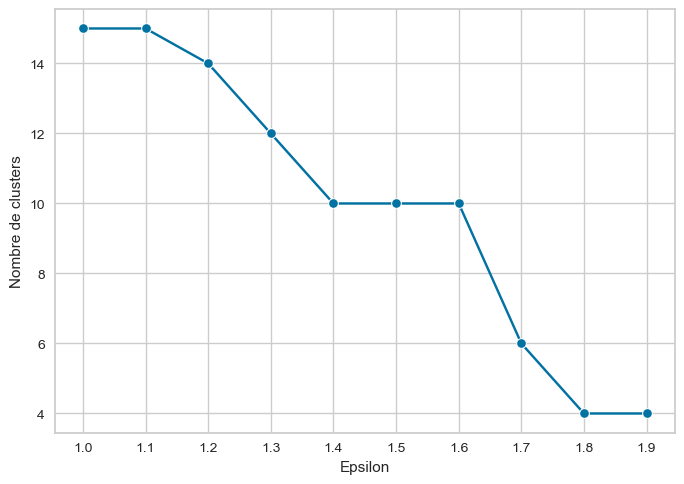

In [23]:
# plot number of clusters on epsilon
sns.lineplot(x=np.arange(1, 2, 0.1), y=db_clusters, marker="o", dashes=False)
plt.xticks(np.arange(1, 2, 0.1))
plt.xlabel("Epsilon")
plt.ylabel("Nombre de clusters")
plt.show()

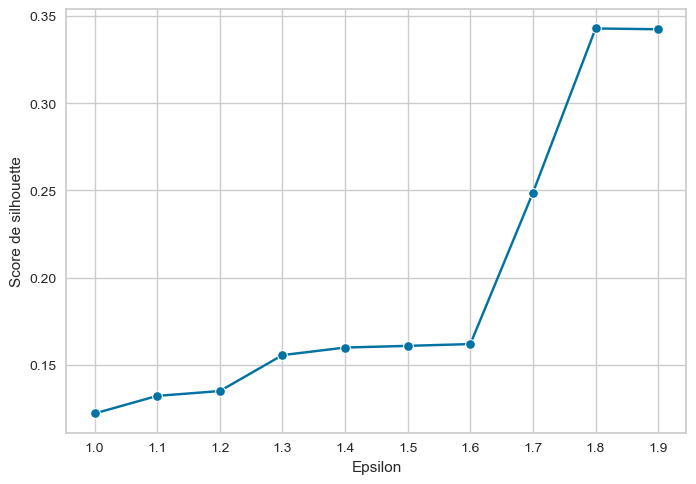

In [24]:
# plot silhouette scores on epsilon
sns.lineplot(x=np.arange(1, 2, 0.1), y=db_silhouettes,
             marker="o", dashes=False)
plt.xticks(np.arange(1, 2, 0.1))
plt.xlabel("Epsilon")
plt.ylabel("Score de silhouette")
plt.show()

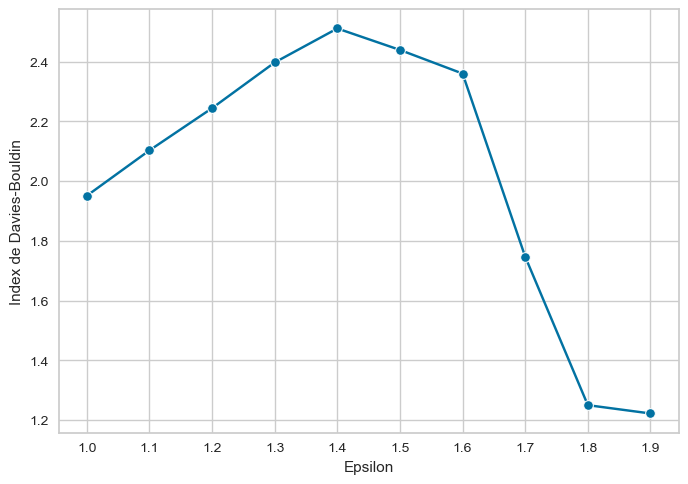

In [25]:
# plot davies-bouldin indexes on epsilon
sns.lineplot(x=np.arange(1, 2, 0.1), y=db_indexes, marker="o", dashes=False)
plt.xticks(np.arange(1, 2, 0.1))
plt.xlabel("Epsilon")
plt.ylabel("Index de Davies-Bouldin")
plt.show()

Le meilleur modèle a pour epsilon 1.7 et min_samples 5. On obtient 6 clusters (en réalité 5 clusters et les outliers en -1).

- Epsilon : 1.7000000000000006, avec 6 clusters : {0, 1, 2, 3, 4, -1}
- Epsilon : 1.7000000000000006, avec un score de silhouette de : 0.24878467250166653
- Epsilon : 1.7000000000000006, avec un index de Davies-Bouldin de : 1.7466887917901752

In [26]:
# instantiate DBSCAN with epsilon = 1.7
dbscan = cluster.DBSCAN(eps=1.7, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

In [27]:
# create dataframe with each client (x and y coordinates) in each cluster
db_tsne = pd.DataFrame(
    {'x': np_tsne[:, 0], 'y': np_tsne[:, 1], 'labels': db_labels})

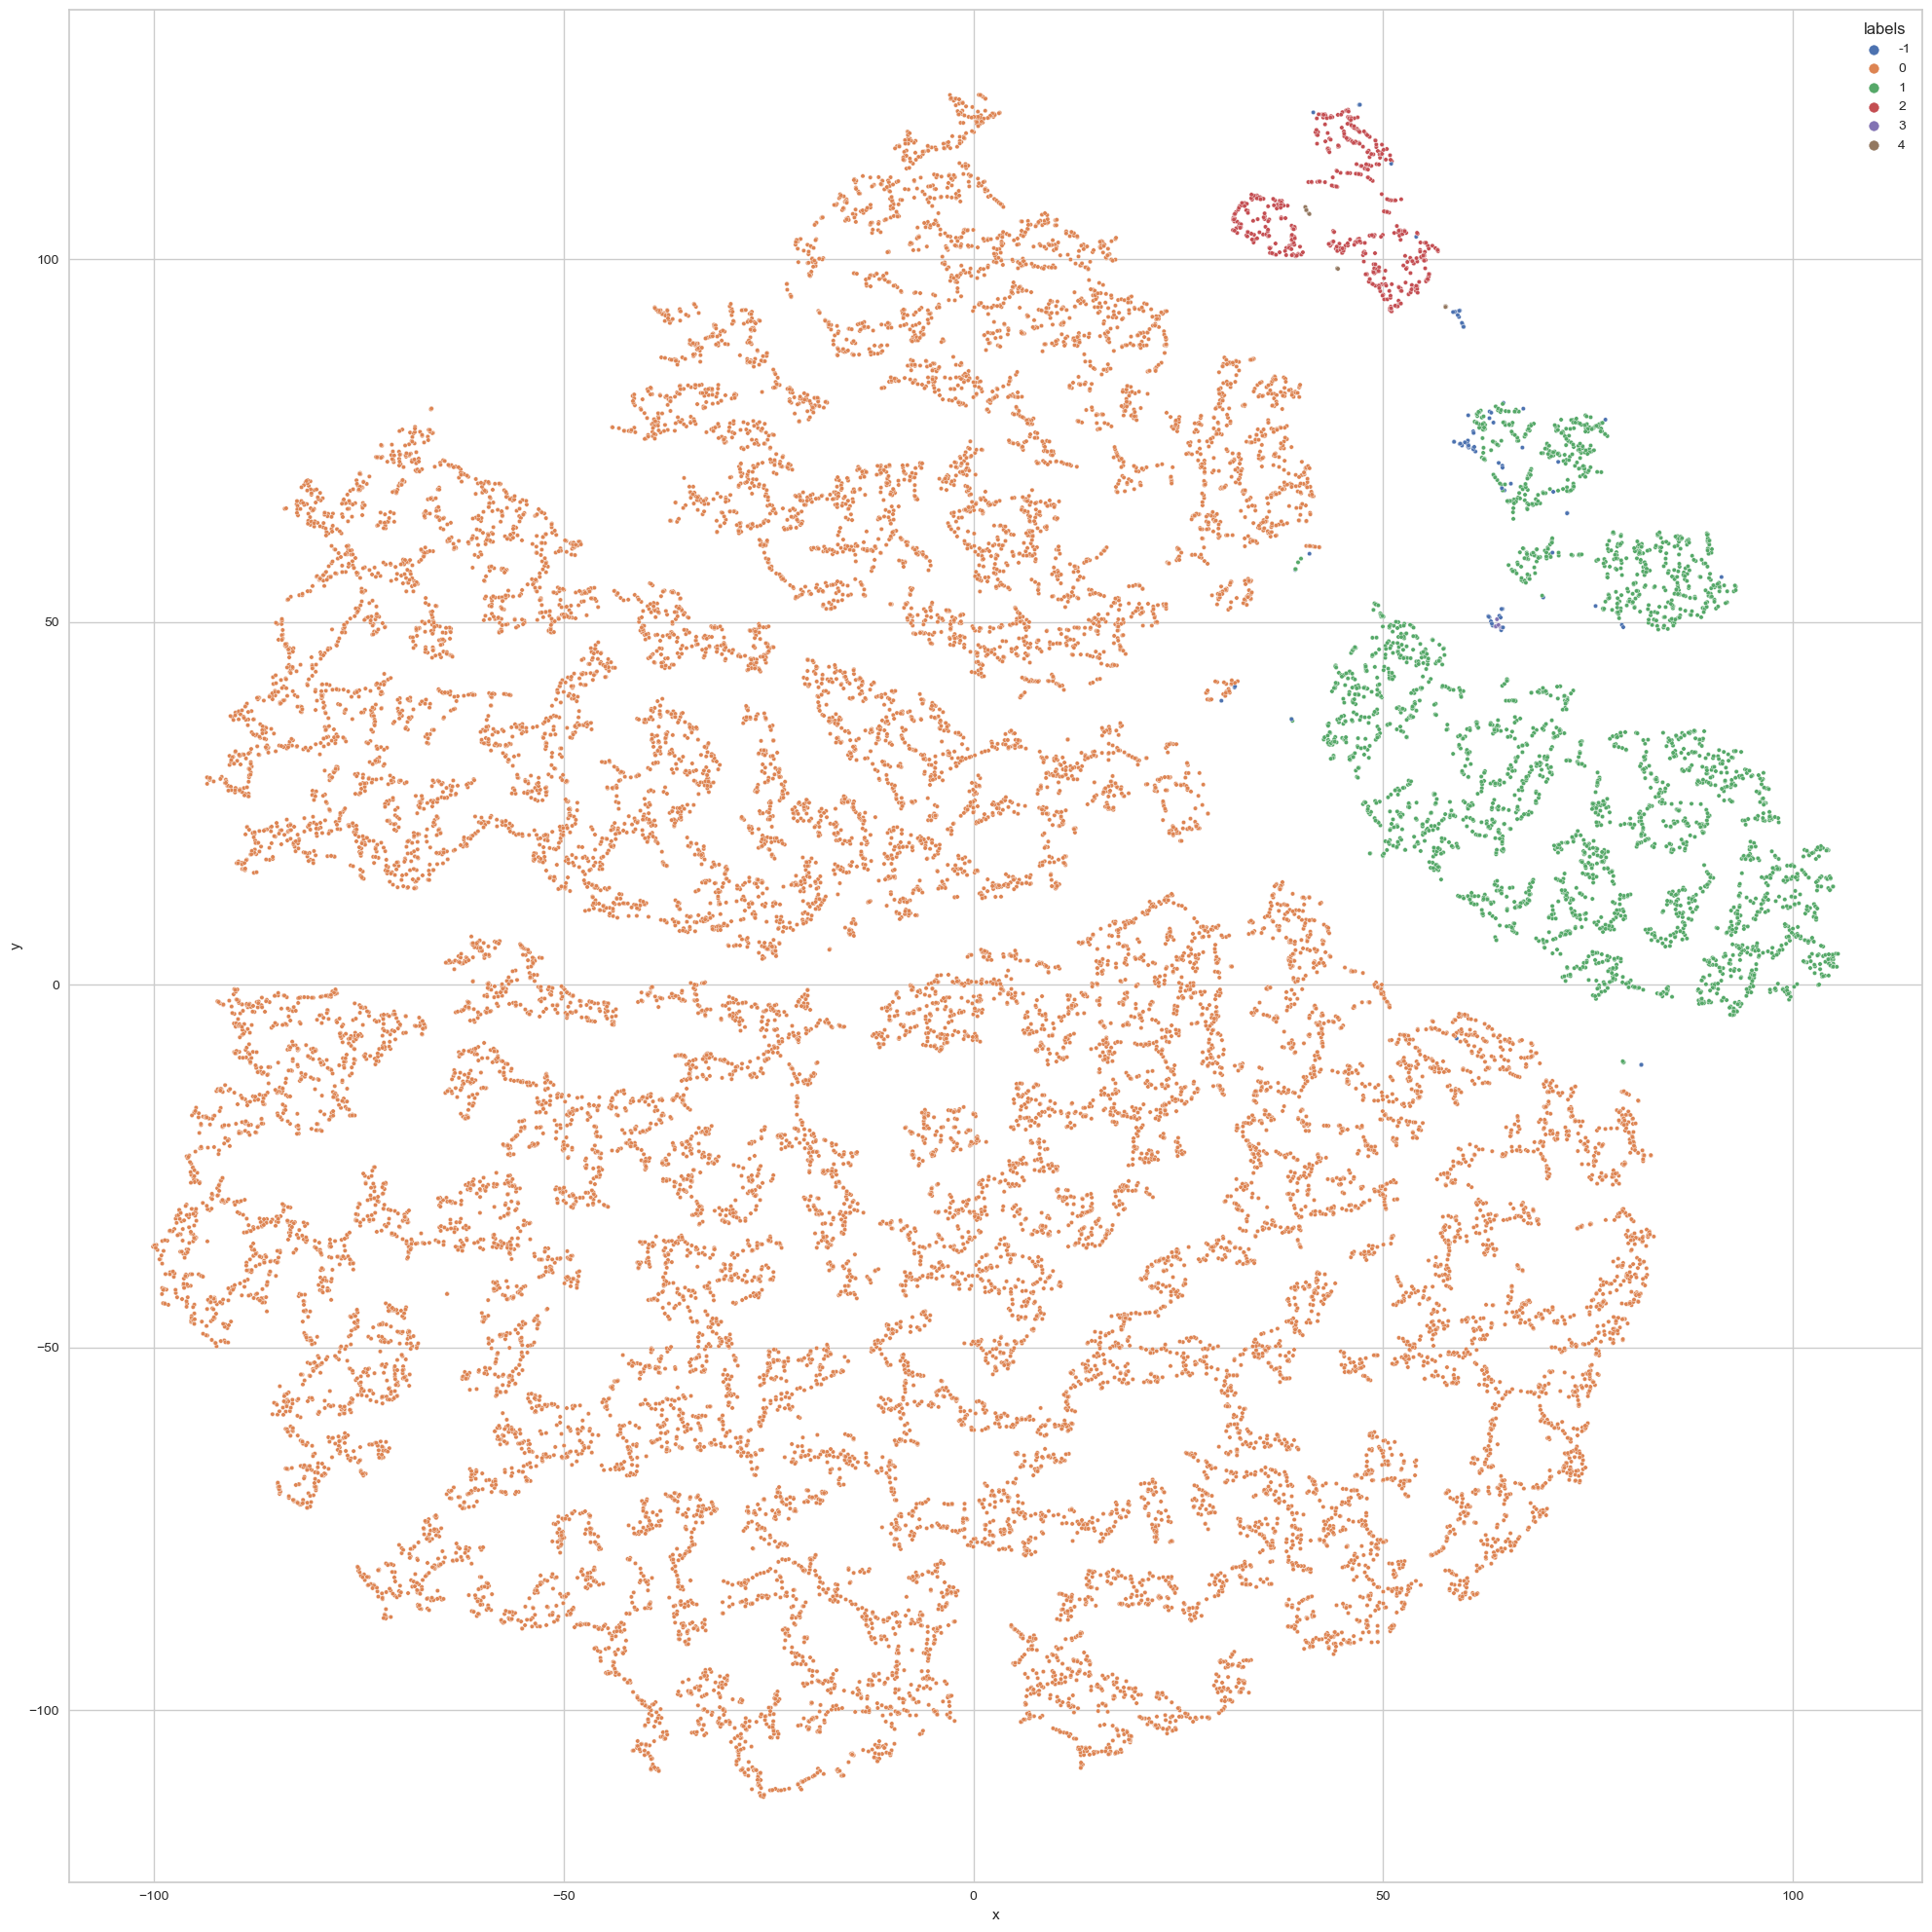

In [28]:
# plotting clusters
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
sns.scatterplot(x=db_tsne['x'], y=db_tsne['y'], s=10,
                hue=db_tsne['labels'], palette="deep")

plt.tight_layout()
plt.show()

### 3.4. Choix du meilleur modèle

Récapitulons les scores :

Pour k-means :

- Nombre de clusters : 6, avec un score de silhouette de : 0.21136819352243938
- Nombre de clusters : 6, avec un index de Davies-Bouldin de : 1.222511314852704

Pour DBSCAN :

- Epsilon : 1.7000000000000006, avec 6 clusters : {0, 1, 2, 3, 4, -1}
- Epsilon : 1.7000000000000006, avec un score de silhouette de : 0.24878467250166653
- Epsilon : 1.7000000000000006, avec un index de Davies-Bouldin de : 1.7466887917901752

Les scores de silhouette sont assez proches mais l'index de Davies-Bouldin est meilleur pour k-means.

En visualisant les clusters obtenus avec t-SNE, on obtient une meilleur séparation de ceux-ci avec k-means.

Nous allons donc rester sur le modèle k-means pour la suite.

## 4. Caractérisation des clusters

### 4.1. Stabilité à l'initialisation

Lors des premières phases de modélisation, le random_state était fixé à 42. On va effectuer plusieurs runs de modélisation sans le paramètre random_state et comparer les résultats obtenus avec l'adjusted_rand_score.

In [29]:
# instantiate KMeans with 6 clusters and random_state 42
kmeans = cluster.KMeans(n_clusters=6, n_init=1, random_state=42)
# fit datas
kmeans.fit(X_scaled)
# create dataframe to compare clusters
kmeans_labels = pd.DataFrame(kmeans.labels_, columns=['random_state 42'])

In [30]:
"""
in range 0 to 12, get clusters from each training without fixed random_state
its allows to see if clusters are stable independently of the random_state
"""
for i in range(12):
    kmeans = cluster.KMeans(n_clusters=6, n_init=1)
    kmeans.fit(X_scaled)
    kmeans_labels['run_{}'.format(i)] = kmeans.predict(X_scaled)

In [31]:
# calcultate adjusted_rand_score fort each pass
kmeans_adjusted_rand_scores = []
for col in range(0, 12):
    kmeans_rand_score = adjusted_rand_score(
        kmeans_labels.iloc[:, 0], kmeans_labels.iloc[:, col+1])
    kmeans_adjusted_rand_scores.append(kmeans_rand_score)

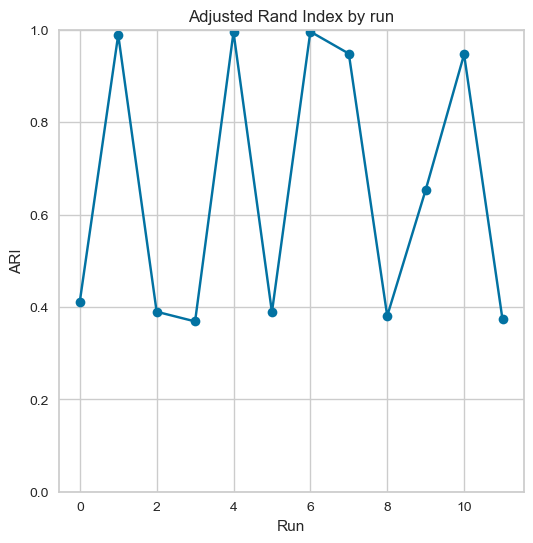

In [32]:
# plot adjusted_rand_scores
plt.figure(figsize=(6, 6))
plt.plot(range(0, 12), kmeans_adjusted_rand_scores, marker='o')
plt.title('Adjusted Rand Index by run')
plt.xlabel('Run')
plt.ylabel('ARI')
plt.ylim((0, 1))
plt.show()

Le Adjusted Rand Index fluctue d'un run à un autre mais reste majoritairement au niveau de 0.4. Les clusters sont dans l'ensemble stables peu importe l'initialisation des données.

### 4.2. Silhouette plot

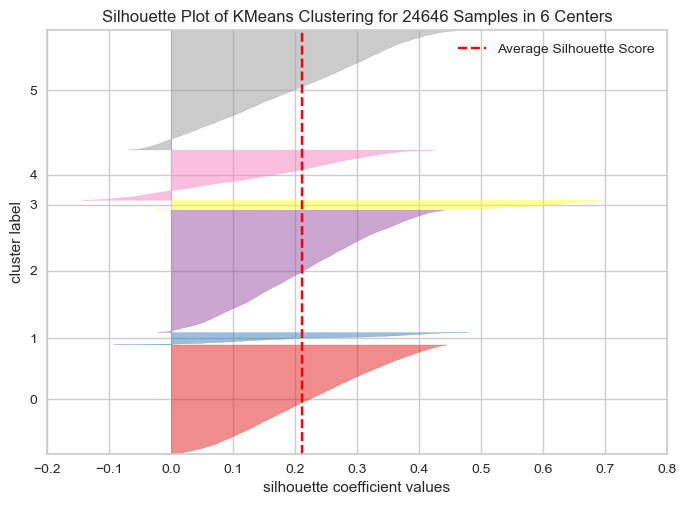

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 24646 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
"""
The Silhouette Visualizer displays the silhouette coefficient for each sample on a per-cluster basis, 
visualizing which clusters are dense and which are not. 
This is particularly useful for determining cluster imbalance, 
or for selecting a value for K by comparing multiple visualizers.
"""
model = cluster.KMeans(random_state=42, n_clusters=6, n_init=1)

visualizer = SilhouetteVisualizer(model)

# Fit the data to the visualizer
visualizer.fit(X_scaled)
visualizer.show()

### 4.3. Description des clusters

On récupère le numéro de cluster pour chaque individu. 
On trace ensuite pour chaque variable, la proportion d'individus par cluster.

In [34]:
model.fit(X_scaled)
X['cluster'] = model.predict(X_scaled)

In [35]:
palette = sns.color_palette("colorblind", 5).as_hex()

In [36]:
variables = ['mean_delivery_time', 'mean_price', 'mean_review_score',
             'total_price', 'total_orders', 'delivered_ratio', 'recency']

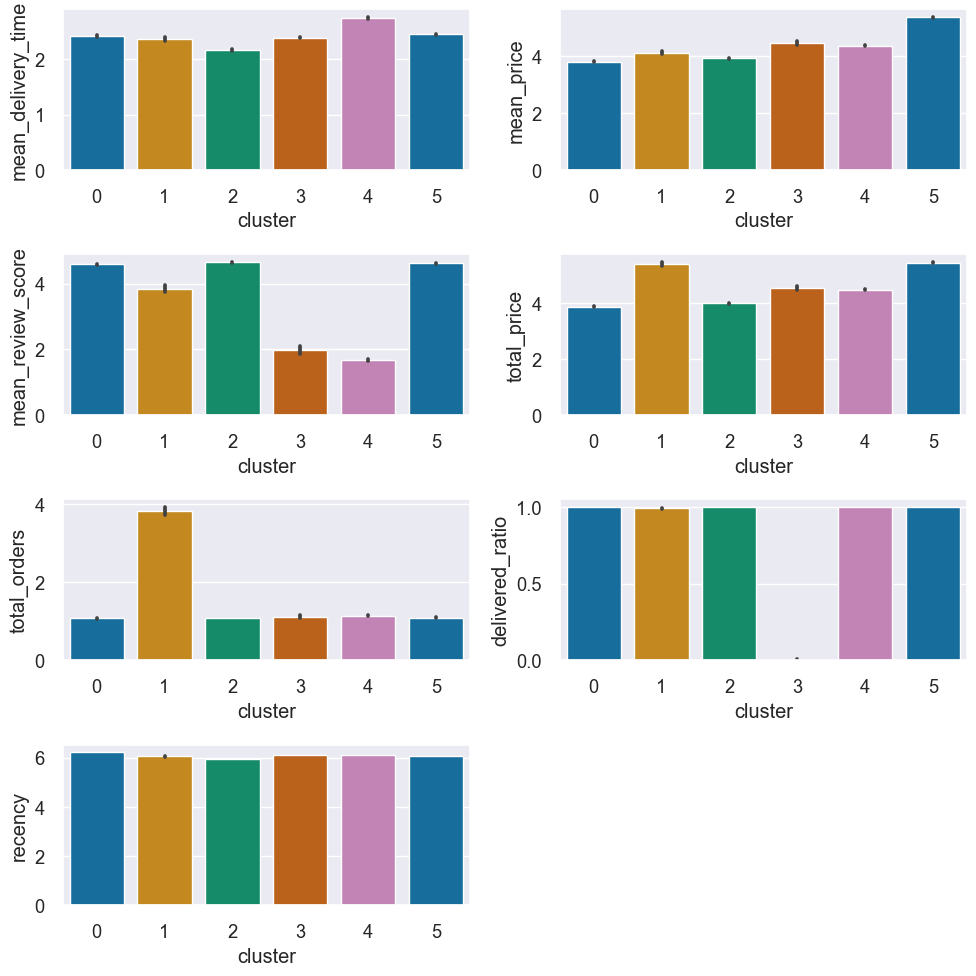

In [37]:
plt.figure(figsize=(10, 10))

sns.set(font_scale=1.2)
i = 1
for var in variables:
    ax = plt.subplot(4, 2, i)
    sns.barplot(data=X, x='cluster', y=var, palette=palette)
    i += 1
plt.tight_layout()

Les clusters de clients qui se détachent le plus :

- le 1 qui ont un un prix d’achat plus élevé que les autres, ils ont aussi passé le plus de commandes. Ce sont les clients les plus fidèles. Ils ont tendance à être moins généreux sur les notes que d’autres.
- le 5 qui sont ceux qui dépensent le plus avec le prix moyen et le prix total le plus élevé. Ils ont tendance aussi à bien noter.

Nous avons aussi :
- le 2, le client moyen qui ne dépense pas plus que les autres mais qui note bien ses commandes,
- le 3 qui n’a pas reçu ses commandes, ça se ressent sur les notes qui sont assez faibles,
- le 4, qui attend le plus pour recevoir ses commandes et ça se ressent encore plus sur ses notes qui sont les plus mauvaises.